In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy import constants as const

import scipy.integrate as integrate

import time

In [2]:
#density functions
R0 = 8500.0*u.parsec #galactic radius of earth

def rho_baryon(r,z,q):
    A = 0.04*u.solMass/(u.parsec**3)
    hr = 3000.0*u.parsec
    R0 = 8500.0*u.parsec
    hz = 400.0*u.parsec
    return A*np.exp(-1*(r - R0)/hr)*np.exp(-1*np.abs(z)/hz)
    
def rho_semis(r, z,q):
    R = np.sqrt(r**2 + (z/q)**2)
    A = 0.03 *u.solMass / (u.parsec**3) #originally 0.0079
    R0 = 8500.0*u.parsec
    Rc = 5000.0*u.parsec
    #print(r,z,R)
    return A*(R0**2 + Rc**2)/(q*(R**2 + Rc**2))

def galcoord(d, l, b):
    R0 = 8500.0*u.parsec #galactic radius of earth
    z = d*np.sin(b)
    l = l*np.pi/180
    b = b*np.pi/180
    r = np.sqrt(R0**2 + (d*np.cos(b))**2 - 2.0*R0*d*np.cos(b)*np.cos(l))
    return r,z

def density(x,D,l,b,q,rhofunc):
    d = D*x
    r,z = galcoord(d,l,b)
    return rhofunc(r,z,q)
    


In [3]:
#use 2 sigma error bars on poisson distribution to get exclusion bounds, look up scipy functions?
#do for 2 and 5 sigma on poisson distributions
#do for different masses when doing dark disk (milky way disk, plus some modified version) vs virialized semi-isothermal distribution

v_c = 220*u.km/u.s #different?
R0 = 8500.0*u.parsec #galactic radius of earth

def rE(m, x, L):
    return np.sqrt(4*m*L*x*const.G*(1.0-x)/const.c**2).decompose()

def t_hat(m):
    return 130*np.sqrt(m/u.solMass)*u.day

def argument_starmass(m,L,t,l,b,q,rho_baryon):
    return m**-2.35*integrate.quad(dGdt_arg, 0.0, 1.0, args = (m,L,t,l,b,1.0,rho_baryon))[0]
 
def expfac(m,x,L,t):
    arg = -4*rE(m,x,L)**2/(t**2*v_c**2).decompose()
    return np.exp(arg)

def dGdt_arg(x,m,L,t,l,b,q,rhofunc):
    tu = t*u.day
    m = m*u.solMass
    return (u.day**2*32.0*L*density(x,L,l,b,q,rhofunc)*rE(m,x,L)**4*expfac(m,x,L,tu)/(tu**4*m*v_c**2)).decompose()

def dGdt(t,m,L,cutoff,l,b,q):
    output_DM = integrate.quad(dGdt_arg, 0.0, 1.0, args = (m,L,t,l,b,q,rho_semis))[0]
    
    lowm = np.maximum(0.01,0.01*(t/130)**2)
    highm = np.maximum(1,100*(t/130)**2)
    print('halfway there')
    #output_B = integrate.quad(argument_starmass, lowm, highm, args = (L,t,l,b,q,rho_baryon))[0]
    output_B = integrate.quad(dGdt_arg, 0.0, 1.0, args = (0.36,L,t,l,b,1.0,rho_baryon))[0]
    unc_B = np.sqrt(output_B)
    req_B = unc_B #np.maximum(1.0,unc_B)
    print(t, output_DM, output_B, unc_B, req_B)
    return output_DM*(np.greater(t,cutoff)*np.sqrt(1000.0 +  t))/req_B #used to have *(1000.0 +  t)

def N(m,L,cutoff,l,b,q, want_B):
    L = L*1000*u.parsec #distance to the source, from kpc to pc
    llim = np.log10(np.maximum(cutoff,10*np.sqrt(m)))
    ulim = np.log10(np.maximum(cutoff*1000,10000*np.sqrt(m)))
    #print(llim, ulim)
    n = 30
    T = np.logspace(llim, ulim, n)
    N_B = np.logspace(llim, ulim, n)
    N_D = np.logspace(llim, ulim, n)
    rat = np.logspace(llim, ulim, n)
    step = T - np.roll(T,1)
    step[0] = 0
    
    i = 0
    for t in T:
        if want_B: N_B[i] = 17e9*integrate.quad(dGdt_arg, 0.0, 1.0, args = (0.36,R0,t,l,b,q,rho_baryon))[0]*(t+4400)*step[i] #use average sqrt(mass) insted of average mass
        N_D[i] = 17e9*integrate.quad(dGdt_arg, 0.0, 1.0, args = (m,R0,t,l,b,q,rho_semis))[0]*(t+4400)*step[i]
        if (N_B[i] < 1.0):
            N_B[i] = 1.0
        if (N_D[i] < 1.0):
            N_D[i] = 1.0
            
        
        if want_B: rat[i] =  N_D[i]/np.sqrt(N_B[i]) #get correct normalizations? Think of a grid
        #print(t, N_B[i], N_D[i], rat[i])
        i = i+1
    if want_B: 
        chis = np.sqrt(np.sum(rat**2))
    else:
        chis = np.sqrt(np.sum(N_D**2))
    
    #plt.loglog(T, N_B, label = 'baryon')
    #plt.loglog(T,N_D, label = 'DM')
    #plt.loglog(T,np.sqrt(N_B), label = 'sqrt(B)')
    #plt.loglog(T,rat, label = 'ND/sqrt(NB)')
    #plt.loglog(T,step,label = 'stepsize')
    #plt.legend()
    
    return chis

In [ ]:
#def N(m,L,cutoff,l,b,q):
#    L = L*1000*u.parsec
#    llim = np.maximum(cutoff,10*np.sqrt(m))
#    ulim = np.maximum(cutoff*100,1000*np.sqrt(m))
#    output = integrate.quad(dGdt, llim, ulim,args = (m,L,cutoff,l,b,q))
#    return output[0]#*1000

In [19]:
def logsense(m,m0,mr):
    return 1.0/(1.0 + (m/m0)**(-1.0/mr))

hdu = fits.open('galaxy1.fits')
data = hdu[1].data    

In [18]:
#calculate baryonic microlensing rate for a bunch of the sources
hdu = fits.open('galaxy1.fits')
data = hdu[1].data    

N_sources = 10
res = np.int(data.size/N_sources)
B_rate = np.array([])

for s in data[::res]:
    Nb = N(m,s['rad'], cutoff, s['glon'], s['glat'],q)
    B_rate = np.append(B_rate, Nb)
    print('done for another source.')
    

NameError: name 'm' is not defined

In [17]:
hdu = fits.open('../GalaxiaData/LSST.fits')
data = hdu[1].data    

def N_looped(m,cutoff,N_sources,q):
    #import LSST Sources from Galaxia
    res = np.int(data.size/N_sources)
    N_ev = 0
    for s in data[::res]:
        N_ev = N_ev + N(m,s['rad'], cutoff, s['glon'], s['glat'],q)
        print('done for another source.')
    return N_ev*1e9/N_sources

FileNotFoundError: [Errno 2] No such file or directory: '../GalaxiaData/LSST.fits'

In [9]:
#np.savetxt('sphericallity_1source.txt', result_array_qc)
#np.savetxt('sphericallity_10source.txt', result_array_q10)
#np.savetxt('sphericallity_10source.txt', result_array_q10)

result_array_q = np.loadtxt('sphericallity_5source.txt')
result_array_qc = np.loadtxt('sphericallity_1source.txt')
result_array_q10 = np.loadtxt('sphericallity_10source.txt')

In [21]:
Q = np.linspace(0.01,1,num = 10)
result_array_qc = np.array([])
for q in Q:
    n = 1e9*N(1.0,8.5,1.0,0.0,0.0,q)
    result = (q,n)
    result_array_qc = np.append(result_array_qc, result)
    print(q,n)

0.01 646270.1227774947
0.12 53855.843881582245
0.23 28098.701155608127
0.34 19007.944899381968
0.45 14361.558368421933
0.56 11540.537974624765
0.67 9645.822784761
0.78 8285.514443320346
0.89 7261.462096393112
1.0 6462.7012657898695


In [57]:
n_newBaryon = N(1.0,8.5,1.0,0.0,0.0,1.0, True)
print(n_newBaryon)


558.8182153706074


In [46]:
M = np.logspace(-4, 7, num = 25)
result_array_bar = np.array([])
cutoff = 1
nstars = 1.0e9
for m in M:
    start = time.time()
    n_cor = N(m,8.5,1.0,0.0,0.0,1.0, True)
    n_lmc = N(m,50,1.0,280,-32,1.0, True)
    result = (m,n_cor, n_lmc)
    #plt.scatter(m,n, c = 'g')
    result_array_bar = np.append(result_array_bar, result)
    end = time.time()
    tim = end - start
    print(m,n_cor, n_lmc,tim)

np.savetxt('basic_constraints_bar.txt', result_array_bar)


0.0001 204778.38487326188 340963.97119239345 15.81917405128479
0.0002872984833353666 398171.4500092309 660479.1470564423 15.57265567779541
0.0008254041852680181 414573.7383390792 680315.1035435317 15.627584218978882
0.0023713737056616554 181645.2714647061 295050.8666038173 15.589418649673462
0.006812920690579608 57018.27322485963 93369.06065514404 16.077709436416626
0.019573417814876596 15175.589686182677 26010.183375530454 15.50469446182251
0.05623413251903491 4063.248918810835 8151.528750249396 15.084186553955078
0.1615598098439873 1152.6732496213046 3601.065863439158 13.983020782470703
0.46415888336127775 579.7411299210269 2839.570036350131 13.529995203018188
1.333521432163324 576.2573964477152 3158.626831992545 12.665688514709473
3.831186849557285 700.4854113918273 3929.46981982227 12.820713996887207
11.00694171252208 901.8831448375665 5049.739363787893 12.247986555099487
31.622776601683793 1190.5859040606508 6405.784436710588 14.463681697845459
90.85175756516861 1600.4164617882295

In [54]:
M = np.logspace(-4, 7, num = 25)
result_array_nobar = np.array([])
cutoff = 1
nstars = 1.0e9
for m in M:
    start = time.time()
    n_cor = N(m,8.5,1.0,0.0,0.0,1.0, False)
    n_lmc = N(m,50,1.0,280,-32,1.0, False)
    result = (m,n_cor, n_lmc)
    #plt.scatter(m,n, c = 'g')
    result_array_nobar = np.append(result_array_nobar, result)
    end = time.time()
    tim = end - start
    print(m,n_cor, n_lmc,tim)

np.savetxt('basic_constraints_nobar.txt', result_array_nobar)


0.0001 3217889.39488471 1256904.2536829947 5.47785758972168
0.0002872984833353666 6469746.273300671 2518593.8749863193 5.594858407974243
0.0008254041852680181 7728519.7849703 2983866.858930156 6.4831647872924805
0.0023713737056616554 5155392.335177498 1976832.2140623042 7.0677244663238525
0.006812920690579608 3053116.19263805 1170006.96365273 7.04031777381897
0.019573417814876596 1802658.9027543212 690803.0385322875 6.944941282272339
0.05623413251903491 1064780.1756287403 408042.617326721 7.834611654281616
0.1615598098439873 629450.7438548256 241221.25731703063 7.031805992126465
0.46415888336127775 372617.9203928172 142801.07922345487 6.574849843978882
1.333521432163324 221093.90139456026 84735.99217649293 7.35538125038147
3.831186849557285 131699.9555650767 50479.59756058974 6.800562143325806
11.00694171252208 78962.06345363145 30270.06980749116 6.532358407974243
31.622776601683793 47851.692227699976 18348.369143094922 6.479923248291016
90.85175756516861 29503.0294950396 11317.0542742

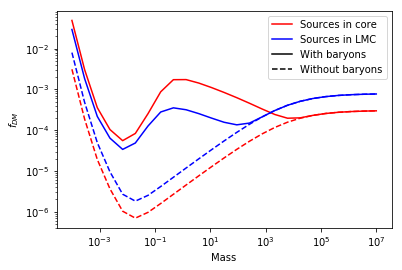

In [5]:
result_array = np.loadtxt('basic_constraints_bar.txt')
m = result_array[0::3]
f_cor = 1.0/result_array[1::3]
f_lmc = 1.0/result_array[2::3]

result_array = np.loadtxt('basic_constraints_nobar.txt')
m = result_array[0::3]
fn_cor = 1.0/result_array[1::3]
fn_lmc = 1.0/result_array[2::3]

plt.loglog(m,f_cor/logsense(m,1e-2,0.5), c = 'r', label = "Sources in core")#, label = 'More Massive Halo')
plt.loglog(m,fn_cor/logsense(m,1e-2,0.5), 'r--')#, label = 'More Massive Halo')

plt.loglog(m,f_lmc/logsense(m,1e-2,0.5), c = 'b', label = "Sources in LMC")#, label = 'More Massive Halo')
plt.loglog(m,fn_lmc/logsense(m,1e-2,0.5), 'b--')#, label = 'More Massive Halo')

plt.loglog([],[], 'k', label = "With baryons")
plt.loglog([],[], 'k--', label = "Without baryons")

plt.legend()
plt.xlabel('Mass')
plt.ylabel('$f_{DM}$')

plt.savefig('fdm_variable_baryonic_microlensing_cor_vs_lmc.svg')

1.0 0.00022854380887586727
1.4384498882876628 0.2924089456300632
2.0691380811147897 6.249007598789051
2.976351441631318 10.730571890188532
4.281332398719393 7.978828138377608
6.158482110660264 14.12059947115071
8.858667904100825 20.609598903972906
12.742749857031335 30.60323812877771
18.329807108324356 48.651283679884465
26.366508987303583 118.68797642069377
37.926901907322495 280.28127044699283
54.55594781168517 357.676797106897
78.47599703514611 288.0442272681465
112.88378916846884 181.17146126833455
162.3776739188721 101.00257218766245
233.57214690901213 53.33265721233614
335.9818286283781 27.59910741716717
483.2930238571752 14.249690228326104
695.1927961775606 7.41151334917931
1000.0 3.9032134927414854
133.15331569575926 78.62981258495287


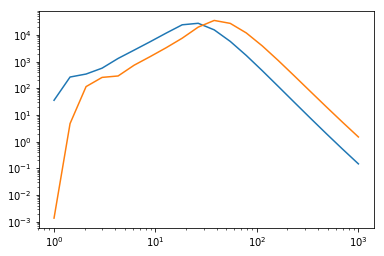

In [30]:
#n_newBaryon = 1e9*N(1.0,8.5,1.0,0.0,0.0,1.0)
#print(n_newBaryon)

def xi(m):
    return m**-2.35
R0 = 8500*u.parsec

def argument_starmass(m,t):
    return m**-2.35*integrate.quad(dGdt_arg, 0.0, 1.0, args = (m,R0,t,0.0,0.0,1.0,rho_baryon))[0]*t
    
n = 20
T = np.logspace(0,3,n)
N_B = np.logspace(0,3,n)
N_D = np.logspace(0,3,n)
rat = np.logspace(0,3,n)

i = 0
for t in T:
    lowm = np.maximum(0.01,0.01*(t/130)**2)
    highm = np.maximum(1,100*(t/130)**2)
    #N_B[i] = 17e9*integrate.quad(argument_starmass, lowm, highm, args = (t))[0]
    N_B[i] = 17e9*integrate.quad(dGdt_arg, 0.0, 1.0, args = (0.36,R0,t,0.0,0.0,1.0,rho_baryon))[0]*(t+1000)
    N_D[i] = 17e9*integrate.quad(dGdt_arg, 0.0, 1.0, args = (1.0,R0,t,0.0,0.0,1.0,rho_semis))[0]*(t+1000)
    rat[i] =  N_D[i]/np.sqrt(N_B[i])
    print(t,rat[i])
    i = i+1
    
plt.loglog(T,N_B)
plt.loglog(T,N_D)

chis = np.sqrt(np.sum(np.power(rat,2))/n)
ssn = np.sum(rat)/n
print(chis, ssn)

In [23]:
Q = np.linspace(0.01,1,num = 10)
result_array_q5 = np.array([])
for q in Q:
    n = N_looped(1.0,1.0,5,q)
    result = (q,n)
    result_array_q5 = np.append(result_array_q5, result)
    print(q,n)
    
np.savetxt('sphericallity_5source.txt', result_array_q5)


done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.01 1622.4258218246362
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.12 6244.1160214833635
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.23 7406.215626149639
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.34 7771.291821943458
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.45 7815.241044507525
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for

In [57]:
nq10[-1]

0.0002044767950099808

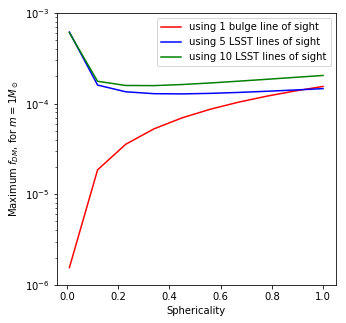

In [29]:
q5 = result_array_q5[0::2]
nq5 = 1.0/result_array_q5[1::2]

qc = result_array_qc[0::2]
nqc = 1.0/result_array_qc[1::2]

q10 = result_array_q10[0::2]
nq10 = 1.0/result_array_q10[1::2]

#q20 = result_array_q20[0::2]
#nq20 = 1.0/result_array_q20[1::2]

plt.figure(figsize = [5,5])
plt.plot(qc,nqc, c = 'r', label = 'using 1 bulge line of sight')
plt.plot(q5,nq5, c = 'b', label = 'using 5 LSST lines of sight')
plt.plot(q10,nq10, c = 'g', label = 'using 10 LSST lines of sight')
#plt.plot(q20,nq20, c = 'm', label = 'using 20 LSST Sources')
#plt.ylim(1e-7,1)
#plt.xlim(0.5,120)
#plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6,1e-3)
plt.legend()
plt.xlabel('Sphericality')
plt.ylabel('Maximum $f_{DM}$, for $m = 1 M_\odot$')
plt.savefig('sphericality_constraints.svg')

In [43]:
M = np.logspace(-4, 2, num = 10)
result_array_l5 = np.array([])
cutoff = 1
nstars = 1.0e9
for m in M:
    start = time.time()
    n = N_looped(m,cutoff,5)
    result = (m,n)
    #plt.scatter(m,n, c = 'g')
    result_array_l5 = np.append(result_array_l5, result)
    end = time.time()
    tim = end - start
    print(m,n,tim)

done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.0001 2767.6311581562168 78.21312427520752
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.00046415888336127773 5952.6641847376795 89.11737608909607
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.002154434690031882 6829.308224746399 108.31378388404846
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.01 6834.9668492482115 117.29126596450806
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
0.046415888336127774 6834.966853777465 117.14

In [50]:
#loop over nuber of LSST sources

nrange = [5,10,50,100]
result_array_lv_realBaryon = np.array([])
cutoff = 1
nstars = 1.0e9
for n in nrange:
    start = time.time()
    Num = N_looped(1.0,cutoff,n,1.0)
    result = (n,Num)
    #plt.scatter(m,n, c = 'g')
    result_array_lv_realBaryon = np.append(result_array_lv_realBaryon, result)
    end = time.time()
    tim = end - start
    print(n,Num,tim)

done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
5 6834.966853777465 114.94016075134277
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
10 4890.530487585101 203.7508580684662
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another source.
done for another sourc

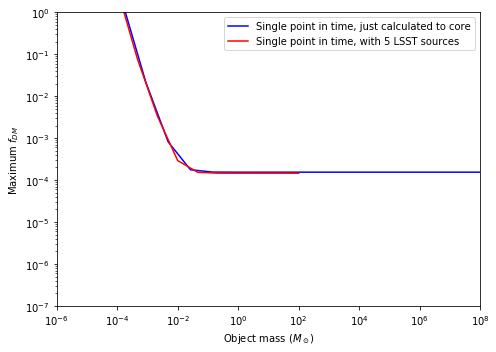

In [44]:
mt = result_array_tau[0::2]
ft = 1.0/result_array_tau[1::2]

ml5 = result_array_l5[0::2]
fl5 = 1.0/result_array_l5[1::2]

plt.figure(figsize = [7,5])

plt.plot(mt, ft/logsense(mt,1e-2,0.5), c = 'b', label = 'Single point in time, just calculated to core')#, label = 'More Massive Halo')
plt.plot(ml5, fl5/logsense(ml5,1e-2,0.5), c = 'r', label = 'Single point in time, with 5 LSST sources')#, label = 'More Massive Halo')
plt.ylim(1e-7,1)
plt.xlim(1e-6,1e8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Object mass ($M_\odot$)')
plt.ylabel('Maximum $f_{DM}$')
plt.legend()
plt.tight_layout()

In [16]:
#for i in data[::10]:
#    print(i['rad'])

In [32]:
data.size

86186

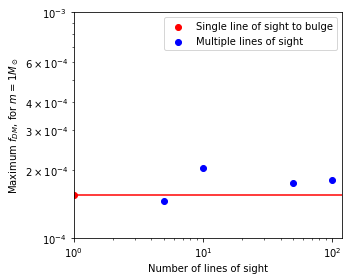

In [13]:
result_array_lv = np.loadtxt('result_array_lv.txt')

nt = result_array_lv[0::2]
ft = 1.0/result_array_lv[1::2]

plt.figure(figsize = [5,4])
plt.plot([1,120], [nqc[-1],nqc[-1]], c = 'r')
plt.scatter(1,nqc[-1], c = 'r', label = 'Single line of sight to bulge')
plt.scatter(nt,ft, c = 'b', label = 'Multiple lines of sight')
plt.ylim(1e-4,1e-3)
plt.xlim(1,120)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of lines of sight')
plt.ylabel('Maximum $f_{DM}$, for $m = 1 M_\odot$')
plt.tight_layout()
plt.savefig('constraints_many_sources.svg')

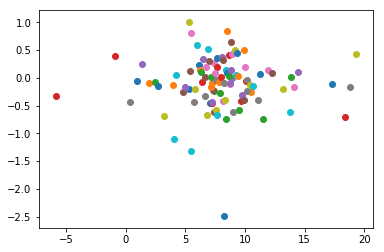

In [53]:
N_sources = 100
res = np.int(data.size/N_sources)
    
for s in data[::res]:
    plt.scatter(s['x'], s['z'])

In [11]:
def shiftlon(glon):
    return 360 - (glon + 180)%360

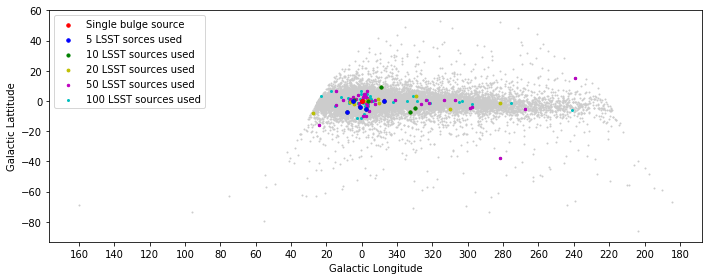

In [28]:
#N_sources = 1000
#res = np.int(data.size/N_sources)

#for s in data[::res]:

plt.figure(figsize = [10,4])

plt.scatter(shiftlon(data['glon']), data['glat'], s = 1, color = '0.8', rasterized = True)


N_sources = 100
res = np.int(data.size/N_sources)
for s in data[::res]:
    plt.scatter(shiftlon(s['glon']), s['glat'], s = 4, color = 'c')

N_sources = 50
res = np.int(data.size/N_sources)
for s in data[::res]:
    plt.scatter(shiftlon(s['glon']), s['glat'], s = 6, color = 'm')

N_sources = 20
res = np.int(data.size/N_sources)
for s in data[::res]:
    plt.scatter(shiftlon(s['glon']), s['glat'], s = 8, color = 'y')

N_sources = 10
res = np.int(data.size/N_sources)
for s in data[::res]:
    plt.scatter(shiftlon(s['glon']), s['glat'], s = 10, color = 'g')

N_sources = 5
res = np.int(data.size/N_sources)
for s in data[::res]:
    plt.scatter(shiftlon(s['glon']), s['glat'], s = 12, color = 'b')
    
plt.scatter(shiftlon(0),0,s = 12, color = 'r', label = 'Single bulge source')
plt.scatter(shiftlon(0),0,s = 12, color = 'b', label = '5 LSST sorces used')
plt.scatter(shiftlon(0),0,s = 10, color = 'g', label = '10 LSST sources used')
plt.scatter(shiftlon(0),0,s = 8, color = 'y', label = '20 LSST sources used')
plt.scatter(shiftlon(0),0,s = 6, color = 'm', label = '50 LSST sources used')
plt.scatter(shiftlon(0),0,s = 4, color = 'c', label = '100 LSST sources used')
plt.scatter(shiftlon(0),0,s = 15, color = 'r')


#ax = plt.axes()
#ax.set_rastarized(True)

plt.legend()

plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Lattitude')

locs = np.arange(0,360,20)

plt.xticks(shiftlon(locs), locs)
plt.tight_layout()

plt.savefig('figures/LSST_sample_sources.pdf')

plt.show()

In [36]:
data['glat'].size

86186